## ACM SIGCHI Summer School on Computational Interaction
#### Inference, optimization and modeling for the engineering of interactive systems
#### 12-17 June 2017
##### Lucerne, Switzerland, ETH Zurich
-----
# Inferring typing behaviour: I

In [1]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors
import sklearn.manifold, sklearn.cluster
import matplotlib.pyplot as plt
#import seaborn as sns
import sys, os, time
import pandas as pd
import pymc as mc
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18.0, 10.0)
import scipy.stats
# fix for pydot on windows machines
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Topic purpose
This section will cover probabilistic **inference**. Rather than learning a single set of parameters by optimisation, we can infer probability distributions over possible models that might be compatible with our data.  


Concretely, we'll use Monte Carlo sampling to make it simple and easy (if not very efficient) to work with probabilistic models. We will use these approaches to model **typing behaviour** at the keystroke level, and both make predictions given some data ("how likely is it that this sequence was typed by user X?") and quantify how much confidence we have in those models.



## Outline for part I (static models)
We will:

[Part I]
* <a href="#keymodel"> Discuss keystroke modelling </a>
* <a href="#graphical "> Look at graphical models of expressions </a>
* <a href="#bayesian"> Get to grips with the basics of Bayesian probabilistic inference </a>
* <a href="#pymc"> Have a quick introduction to probabilistic programming with PyMC </a>


* <a href="#practical"> **Practical**: build a simple Bayesian probabilistic model to model keystroke timings and use MCMC to fit it. </a>

[Part II]
* <a href="inferring_2.ipynb#sampling"> Discuss issues in MCMC sampling. </a>
* <a href="inferring_2.ipynb#bigram"> Look at simple Markov language models. </a>
* <a href="inferring_2.ipynb#imputation">Discuss imputation of missing data. </a>


* <a href="inferring_2.ipynb#challenge"> **Challenge**: build a fully probabilistic model that can predict the *distribution* over the likely next time of a key event. </a>

----

### Keystroke modelling
<a id="keymodel"> </a>
<img src="imgs/keyboard_drawing.png">


Specifically, we'll look at **inter-key timing** data, that you have all been collecting from your notebooks today. This dataset is very simple. It captures a sequence of key events and their timing.
    
This is enough to answer some interesting questions; for example, can we detect which user is typing based on the distribution of inter-key times? Or more precisely, can we infer a **probability distribution** over users that might be generating a timing sequence and update that as we see more keystrokes?

Alternatively, we could see if the type of key hit (e.g. space versus letter, or left side versus right side) influences the timing of the **next** keystroke, and build a predictive model to infer the likely next time to key impact. 

If we are very ambitiuous, we could try and recover the keystrokes themselves from timing alone. There probably isn't enough information to do this, at least without very large user-specific datasets and a robust **language model**, but we could probably identify unusual keys (e.g. identify `space` or `enter` "punctuation" in the timing stream).

The "key" message here is that we are going to build probabilistic models -- we will maintain uncertainty over future possibilities. 

### This is **probabilistic programming**.

We will use a representation where **random variables** are *first-class* values and we can write down our models without writing down the detailed mechanics of inference itself.

---------------

### Why is this computational HCI?
We will build a **statistical model** of user behavior, and estimate parameters of that model from quantitative observations of data. This model is **robust** (it appropriately represents uncertainty) and **generative** (it can simulate behaviour compatible with observations).  

# Background
## Probabilistic approaches
<a id="bayesian"> </a>
#### Random variables
A *random variable* is a variable that can (at some point in the future) take on different values; i.e. one that is "unassigned". Proability theory allows us to manipulate random variables without having to assign them a specific value.

#### Distributions
A *probability* distribution defines how likely different states of a random variable are. The probability distribution of a random variable $X$ is written:
$$P(X)$$
and is shorthand for the expression
$$P(X=x),$$ i.e. that the variable $X$ takes on the specific value $x$.

Random variables can be continuous (e.g. the height of a person) or discrete (the value showing on the face of a dice). The distribution of a discrete variable is described with a *probability mass function* (PMF) which gives each outcome a specific value. A continuous variable has a *probability density function* (PDF) which specifies the spread of the probability as a continuous function.

A probability distribution must assign probabilities in the range 0 (impossible) to 1 (definite) and the PMF or PDF **must** integrate to exactly 1 as the random variable under consideration must take on *some* value. 



In [3]:
# the PMF of the sum of two dice rolls
def two_dice():
    # form the sum of the cross product of these possibilities
    roll_two = [i+j for i in range(1,7) for j in range(1,7)]
    # now plot the histogram
    plt.hist(roll_two, normed=True, bins=range(1,14))
    plt.xlabel("Sum of rolls x")
    plt.ylabel("P(x)")

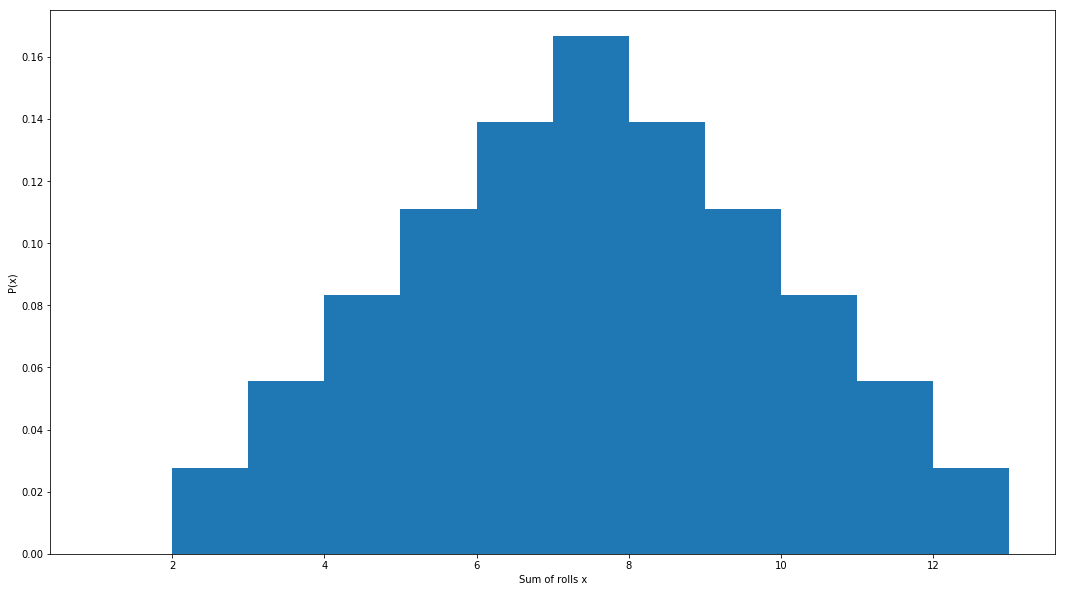

In [4]:
two_dice()

In [5]:
import scipy.stats as stats
# Plot the PDF of the normal distribution
def plot_normal():
    # plot the normal (Gaussian distibution) along with a set of points drawn from that distribution
    x = np.linspace(-4,4,100)
    y = stats.norm.pdf(x,0,1) # mean 0, std. dev. 1
    plt.plot(x,y)
    plt.axhline(0, color='k', linewidth=0.2) # axis line
 
    # mark the mean
    plt.text(0, 0.51, '$\mu$')
    plt.axvline(0, color='r')
    # highlight one std. dev. to the right
    plt.axvspan(0,1, facecolor='b', alpha=0.1)
    plt.text(1.2, 0.3, '$\sigma$')
    # take 1000 random samples and scatter plot them
    samples = stats.norm.rvs(0,1,1000)
    plt.scatter(samples, np.full(samples.shape, .2), s=448, c='b', alpha=0.1, marker='|')
    plt.xlabel("$x$")
    plt.ylabel("$P(x)$")
    

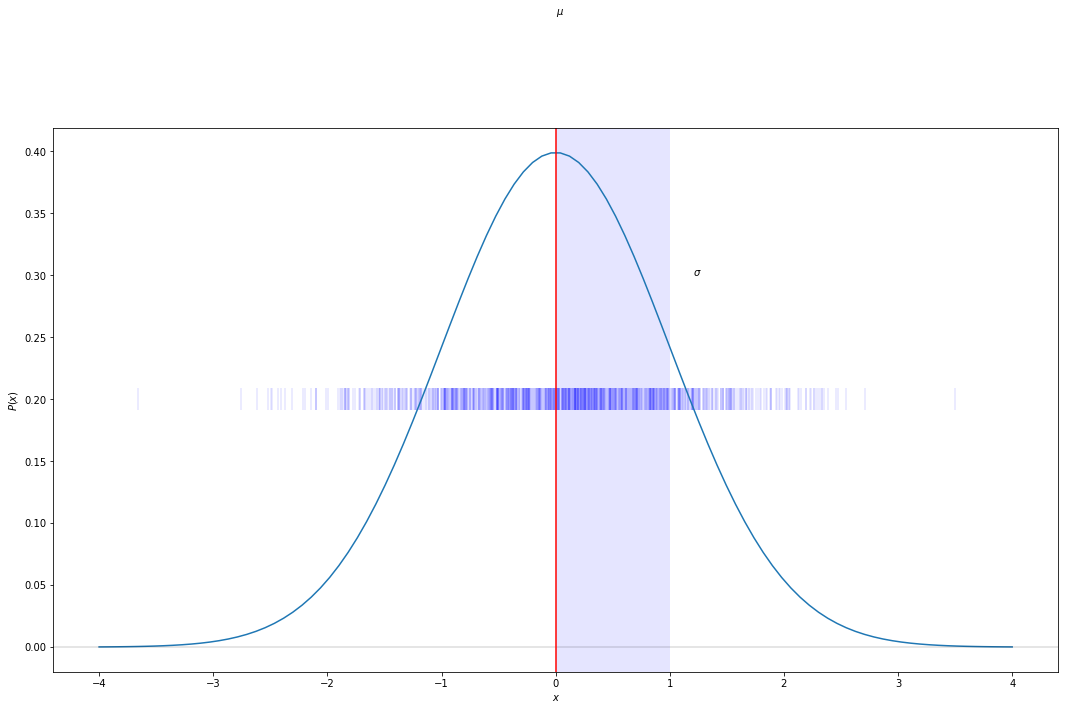

In [6]:
plot_normal()

### Joint, marginal, conditional
The *joint probability* of two random variables is written $$P(x,y)$$ and gives the probability that $x$ and $y$ take the same value *simultaneously*. 

The *marginal probability* is the derivation of $P(x)$ from $P(x,y)$ by integrating (summing) over all the possible choices of $y$:
$$P(x) = \int P(x,y) dy$$.

**Marginalisation** just means integration over one or more variables from a joint distribution: it *removes* those variables from the distribution.

Two random variables are *independent* if the they do not have any dependence on each other. If this is the case then the joint distribution is just the product of the individual distributions:
$P(x,y) = P(x)P(y)$

The *conditional probability* of $x$ **given** $y$ is written as $$P(x|y)$$ and can be computed as $$P(x|y) = \frac{P(x,y)}{P(x)}.$$ This tells us how likely $x$ is to occur **if we already know**  (or fix) the value of $y$.



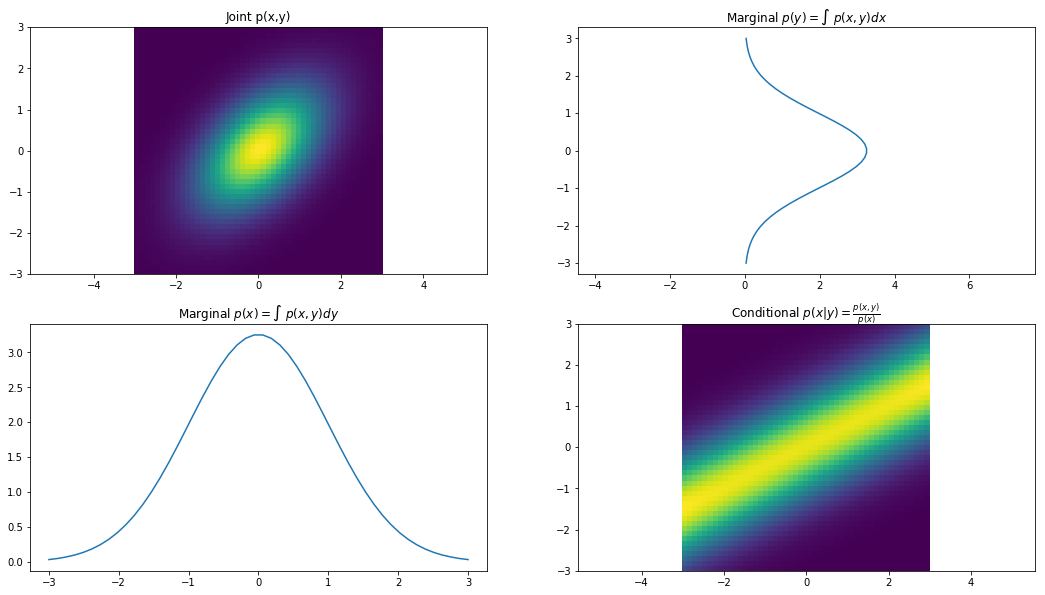

In [7]:
def joint_marginal(cov):
    # create an independent 2D normal distribution
    x,y = np.meshgrid(np.linspace(-3,3,50), np.linspace(-3,3,50))
    pos = np.empty(x.shape + (2,))
    pos[:,:,0] = x
    pos[:,:,1] = y
    joint_pdf = scipy.stats.multivariate_normal.pdf(pos, [0,0], cov)
    fig = plt.figure()
    # plot the joint
    ax = fig.add_subplot(2,2,1)
    ax.axis('equal')
    plt.title("Joint p(x,y)")
    ax.pcolor(x,y,joint_pdf, cmap='viridis')
    # plot the marginals
    ax = fig.add_subplot(2,2,3)
    ax.axis('equal')
    plt.title("Marginal $p(x) = \int\  p(x,y) dy$")
    ax.plot(x[0,:], np.sum(joint_pdf, axis=0))
    ax = fig.add_subplot(2,2,2)
    ax.axis('equal')
    plt.title("Marginal $p(y) = \int\  p(x,y) dx$")
    ax.plot(np.sum(joint_pdf, axis=1), x[0,:])
    # plot p(x|y)
    ax = fig.add_subplot(2,2,4)
    ax.axis('equal')
    plt.title("Conditional $p(x|y) = \\frac{p(x,y)}{p(x)}$")
    marginal = np.tile(np.sum(joint_pdf, axis=0), (joint_pdf.shape[0],1))
    ax.pcolor(x,y,joint_pdf/marginal, cmap='viridis')
joint_marginal([[1,0],[0.5,1]])

## Probability theory and Bayesian inference

#### Probability as a calculus of belief
*Bayesians* treat probability as a **calculus of belief**; in this model of thought, probabilities are measures of degrees of belief. $P(X)=0$ means a belief that $X$ cannot be true and $P(X)=1$ is a belief that $X$ is certainly 1. 


#### Probability as the optimal way of representing uncertainty
Other representations of uncertainty are strictly inferior to probabilistic methods *in the sense that* a person, agent, computer placing "bets" on future events using probabilistic models has the best possible "return" out of all decision systems when there is uncertainty. 

*Bayesians* allow for belief in states to be combined and manipulated via the rules of probability. The key process in Bayesian logic is *updating of beliefs*. Given some *prior* belief (it's Glasgow, it's not likely to be sunny) and some new evidence (there seems to be a bright reflection inside) we can update our belief to calculate the *posterior* -- our new probability that it is sunny outside. Bayesian inference requires that we accept priors over events, i.e. that we must explicitly quantify our assumptions with probability distributions. 

#### Axioms of probability
 
There are only three basic axioms of probability:

1. $$0 \leq P(A) < 1$$ all possible events $A$ -- probabilities are 0, or positive and less than 1.
2. $$\sum_A P(A)=1$$ for the complete set of possible values $A \in \sigma$ in a set of possibilities $\sigma$ -- something always happens.
3. $$P(A \lor B) = P(A) + P(B) - P(A \land B),$$ i.e. the probability of either of $A$ or $B$ happening is the sum of the independent probabilities minus the probability of both happening.

The remainder of the rules of probability can be derived from these three statements, along with the definition of conditional probability:


* The conditional probability $P(A|B)$ means the probability that $B$ will happen *given that we already know $B$ to have happened*.
$$P(A|B) = \frac{P(A \land B)}{ P(B)}$$

### Events
Note that we can see an "event" as a random variable taking on a specific value i.e. $P(X=x)$


#### Prior, likelihood, posterior
We often want to know the probability of a model $H$ (and its parameters $\theta$) given some data $p(H, \theta|D)$. But we can only compute the likelihood of the data being generated by the model. Bayes' rule gives a consistent model for inverting the probability distribution:
$$ p(A|B) = \frac{p(B|A) P(A)}{P(B)} $$

$$ p(H,\theta|D) = \frac{p(D|H,\theta) P(H,\theta)}{P(D)} $$

$P(A|B)$ is called the *posterior*, $P(B|A)$ is called the likelihood, $P(A)$ is the *prior* and $P(B)$ is the *evidence*. Bayes' rule gives a consistent rule to take some prior belief and combine it with observed data to estimate a new distribution which combines them.

In [91]:
def prior_posterior(prior_mean=0, prior_std=1, n=10):
    mean = prior_mean
    std = prior_std
    var = std*std
    prior = scipy.stats.norm(mean,std)
    evidence = scipy.stats.norm(1, 0.25)
    
    xs = np.linspace(-5,5,200)
    plt.fill_between(xs, prior.pdf(xs), label="Prior", alpha=0.1)
    plt.fill_between(xs, evidence.pdf(xs), label="True", alpha=0.1)
    
    sample_var = 1.0 # the *expected* variance of our observations
    # note that changing this allows us to continously adjust our belief
    # in our observations 
    
    for i in range(n):
        
        sample = evidence.rvs()
        # single step update for a normal distribution    
        mean = (var * sample + sample_var * mean) / (sample_var + var)
        var = (var*sample_var) / (sample_var+var)     
        # plot the sample and the resulting pdf
        plt.plot([sample,sample],[0,-0.1], 'c', alpha=0.7)
        plt.plot(xs, scipy.stats.norm(mean,np.sqrt(var)).pdf(xs), 'k:', alpha=0.5)
    plt.plot([sample,sample],[0,-0.1], 'c', alpha=0.7, label="Observations")
        
    plt.fill_between(xs, scipy.stats.norm(mean,np.sqrt(var)).pdf(xs), color='g', label="Posterior", alpha=0.2)
    plt.legend()
 

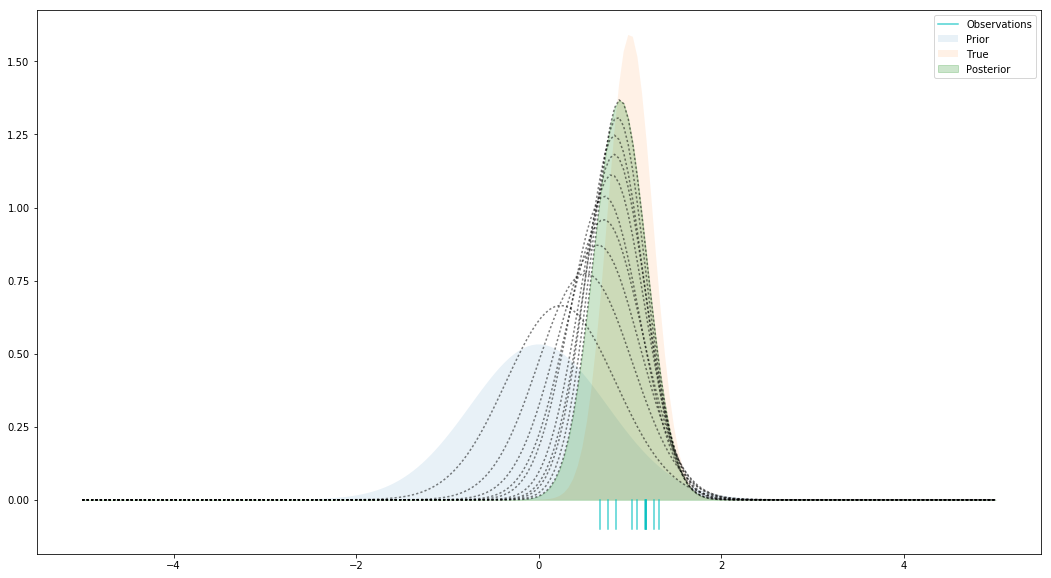

In [92]:
   
prior_posterior(0,0.75)

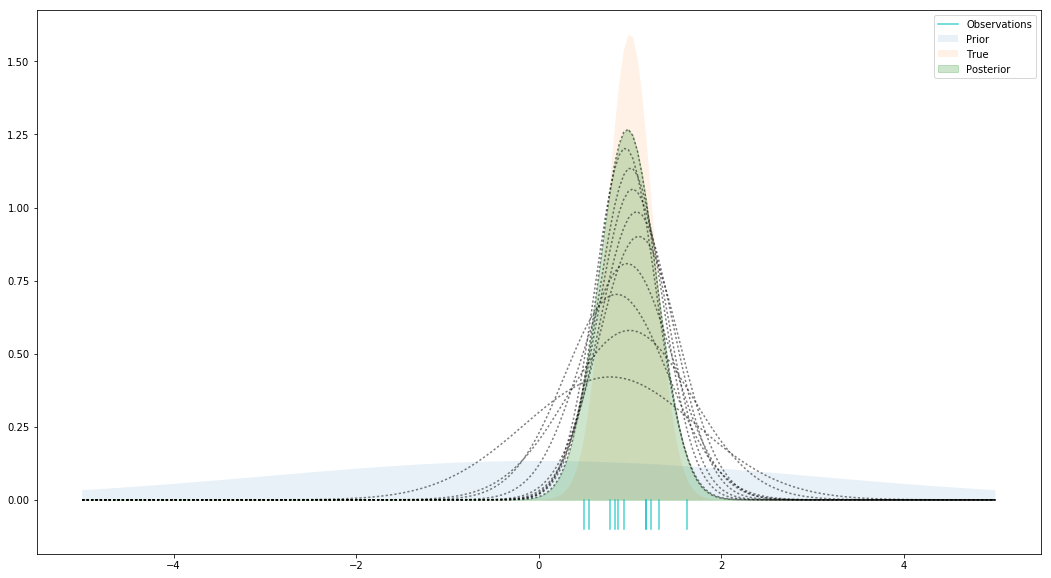

In [93]:
   
prior_posterior(0,3)

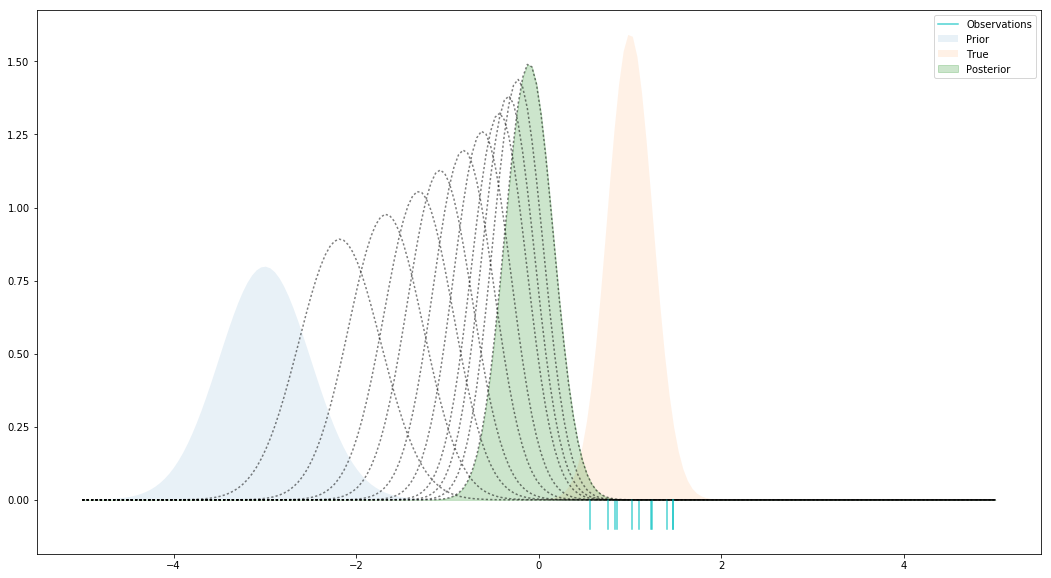

In [94]:
   
prior_posterior(-3,0.5)

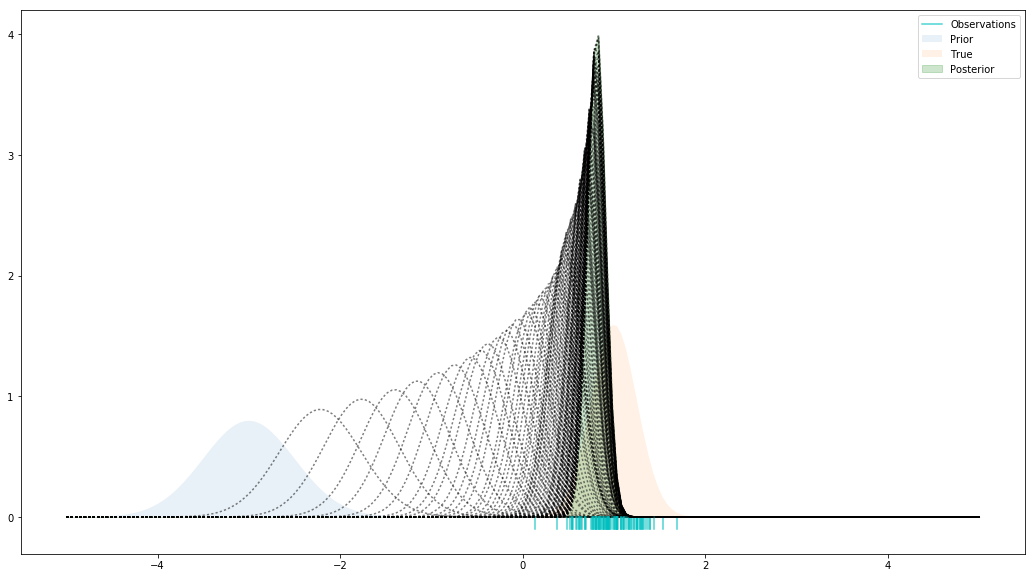

In [95]:
   
prior_posterior(-3,0.5, n=100)

#### Integration over the evidence
We can say that the posterior probability is *proportional* to the product of the prior and the likelihood. But to evaluate its value, we need to compute $P(B)$, the evidence. 
This is tricky, but because probabilities must add up to 1, we can write $P(B)$ as:
$$ P(B)  = \sum_{i} P(B|A_i) P(A_i) $$ 
for a set of discrete possibilities $A_i$ or
$$ P(B) = \int_{A} P(B|A) P(A) dA $$ for a continuous distribution over $A$. 

<font color="green"> This trick is essential in understanding Bayesian inference! </font>

In general this is difficult to compute. For binary simple cases where there are only two possible outcomes ($A$ can only be true or false), Bayes' rule can be written as:

$$P(A|B) = \frac{P(B|A)P(A)}{P(B|A)P(A) + P(B|\bar A) P(\bar A)}, $$ where $\bar A$ means "when A is false". In words:

* The probability that it is sunny given I can see a bright reflection is equal to:
    * The probability that I would see a bright reflection if it *were* sunny times the probability that it might be sunny 
        * over
    * The probability that I would see a bright reflection if it *were* sunny times the probability that it might be sunny plus the probability that I would see a bright reflection if it were *not* sunny times the probability it might not be sunny.
    
-----        

# Representing probabilistic models for computation


#### Graphical models
<a id="graphical"> </a>

Transformations of expressions to graphs is familiar to most computer scientists -- it is an essential part of most optimising compilers. For example, the equation of a straight line might be written as a graph (this is how a compiler would break down the expression):

<img src="imgs/ymxc.png" width="300px">

##### Adding unknowns
If we have multiple dependent random variables whose distribution we want to infer, we can draw a graph of dependencies to form a *graphical model*.  This explictly models dependencies between **random variables** (i.e. ones we don't know the value of precisely) and inference can be performed on the entire graph. 

**In CS terms, we are writing expressions down without fixing the variables, and then allowing the distribution of the values to be inferred when we observe data.** This inference process narrows down the likely range a random variable could take on (hopefully!).

In a **probabilistic graphical model**, some nodes in the graph are **observed** -- that is we know their state because we have explicity measured it, and others are **unobserved** -- we know (or have guessed) the form of their distribution but not the parameters of that distribution. Some dependencies are deterministic (i.e. fully defined by the values of their parents), while others are stochastic. We can infer the **posterior** distribution of unobserved nodes by integrating over the possible values that could have occured given the observed values.

We can modify our straight line equation to write a model for **linear regression**:

<img src="imgs/ymxc_stochastic.png">

All we need to do is specify that we expected the output $y$ to be normally distributed around the equation of a line given by $m$ and $c$; we can now **infer** $\sigma, m, c$ from observed data. Or we can fix any of them, and infer the remainder (if, e.g. we knew in advance that $c=0$). Our assumption here is that we will observe data which has a **latent structure** modelled by a linear dependence on a variable $x$, plus some normally-distributed observation noise.

**Note that we must put *some* prior distribution on every stochastic node.**

### Sampling
We can draw samples from a distribution, which gives us a set of definite (non-random) variables which are distributed according to the PDF or PMF. The sample mean $\mu$ of a set of samples from a distribution is an estimate of the *expectation*, which improves as the number of samples $N$ increases. 

We can write this as:
$$ \frac{1}{N} \sum_{i=0}^{N} x_i \approx E[x] =\int_x p(x) dx,$$ where $x_i$ are random samples from $p(x)$. 

Furthermore, if we want to apply any function $f(x)$ to the distribution (e.g. to answer question like 'what is the expected value of a normal distribution whose "output" is squared'), we can estimate of $E[f(x)]$ very simply:
$$ \frac{1}{N} \sum_{i=0}^{N} f(x_i) \approx E[f(x)] = \int_x f(x) p(x) dx,$$.





### Monte Carlo inference
We often cannot compute the integral to normalise the probability distribution on the bottom of formula for Bayes Rule $P(B)$. 

One common way to get round this is to use *Monte Carlo sampling*, where we approximate the integration over all the parameters by summing over random samples drawn from the distribution of parameters. There are many techinques to do this efficiently, as the naive sampling methods become very inefficient in high dimensional spaces (i.e. $N$ must be very large to reliably sample the space). 

This allows us to solve the tricky denominator in Bayes Rule:

$$ p(A|B) = \frac{p(B|A) P(A)}{P(B)} $$

$$  = \frac{p(B|A) P(A)}{\int_{A} P(B|A) P(A) dA} $$ 

$$  \approx \frac{p(B|A) P(A)}{\frac{1}{N} \sum_{i=0}^{N} P(B|A_i) P(A_i)} $$ 

Since we can usually sample from $P(A)$ easily, this becomes very straightforward to compute (as long as we can sample from P(B|A), but there are tricks to do this even if it has an unpleasant form).

One of these techniques is *Markov chain Monte Carlo* (MCMC) constructs random walks which "wander" about in probablity distributions in a way that makes samples drawn from them represent the true distribution correctly.


---

----

## Let's do it: PyMC
<a id="pymc"> </a>
We'll use the excellent PyMC module to do the inference. If you have questions about this module, you can read [this tutorial](http://arxiv.org/abs/1507.08050) or the [API docs](https://pymc-devs.github.io/pymc/). There's a new and even nicer version with very powerful capabilities currently called **PyMC3**, but the dependencies are "hard" to install at the moment.

Let's implement the linear regression model in the intro in practice, using PyMC to build a graphical model and then run MCMC to sample from the posterior (i.e. estimate the distribution of random variables after seeing some evidence).

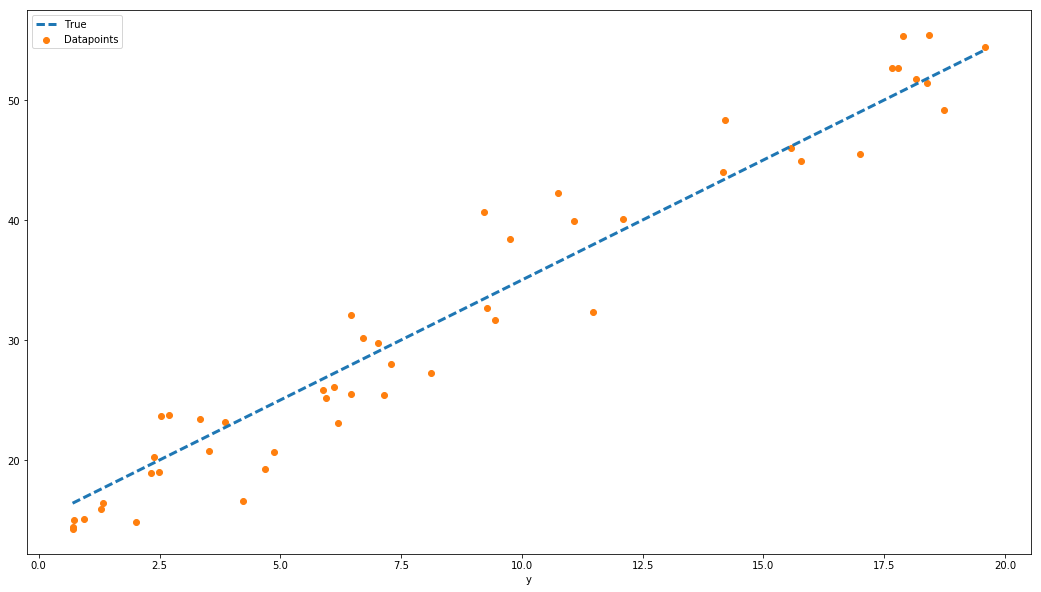

In [9]:
### Bayesian Linear Regression with pymc
### We use Monte Carlo sampling to estimate the distribution of a linear function with a normally
### distributed error, given some observed data.
### Vaguely based on: http://matpalm.com/blog/2012/12/27/dead_simple_pymc/ and http://sabermetricinsights.blogspot.co.uk/2014/05/bayesian-linear-regression-with-pymc.html

## Utility function to plot the graph of a PyMC model
def show_dag(model):
    dag = mc.graph.dag(model)
    dag.write("graph.png",format="png")
    from IPython.display import Image
    i = Image(filename='graph.png')
    return i

## generate data with a known distribution
## this will be our "observed" data
x = np.sort(np.random.uniform(0,20, (50,)))
m = 2
c = 15
epsilon = 3
# Add on some measurement noise, with std. dev. 3.0
noise =   np.random.normal(0,epsilon, x.shape)
y = m * x + c + noise

plt.scatter(x,y, c='C1', label="Datapoints")
plt.plot(x, m*x+c, '--', lw=3, label="True")
plt.legend()
plt.xlabel("x")
plt.xlabel("y")

In [10]:
print("True m: %.2f"%m)
print("True c: %.2f"%c)
print("True epsilon: %.2f"%epsilon)

True m: 2.00
True c: 15.00
True epsilon: 3.00


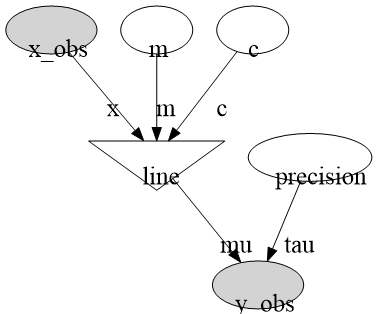

In [11]:
## Now, set up the PyMC model
## specify the prior distribution of the unknown line function variables
## Here, we assume a normal distribution over m and c
m_unknown = mc.Normal('m', 0, 0.01)
c_unknown = mc.Normal('c', 0, 0.001)

## specify a prior over the precision (inverse variance) of the error term
# precision = 1/variance
## Here we specify a uniform distribution from 0.001 to 10.0
precision = mc.Uniform('precision', lower=0.001, upper=10.0)

# specify the observed input variable
# we use a normal distribution, but this has no effect -- 
# the values are fixed and the parameters
# never updated; this is just a way of transforming x 
# into a variable pymc can work with
# (it's really a hack)
x_obs = mc.Normal("x_obs", 0, 1, value=x, observed=True)

@mc.deterministic(plot=False)
def line(m=m_unknown, c=c_unknown, x=x_obs):
    return x*m+c

# specify the observed output variable 
# (note we use tau instead of sigma, the precision paramterisation)
# note that it is critical to realise we are modelling a stochastic output variable
# whose *mean* and *variance* we are inferring
y_obs =  mc.Normal('y_obs', mu=line, tau=precision, value=y, observed=True)

model = mc.Model([m_unknown, c_unknown, precision, x_obs, y_obs])

# display the graphical model
show_dag(model)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.3 sec

(-40, 80)

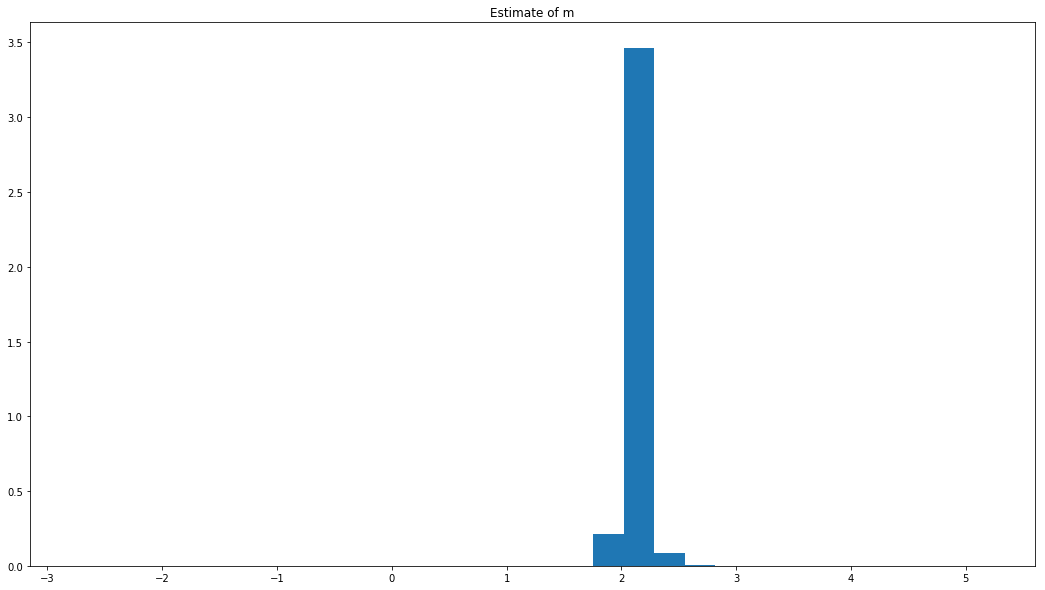

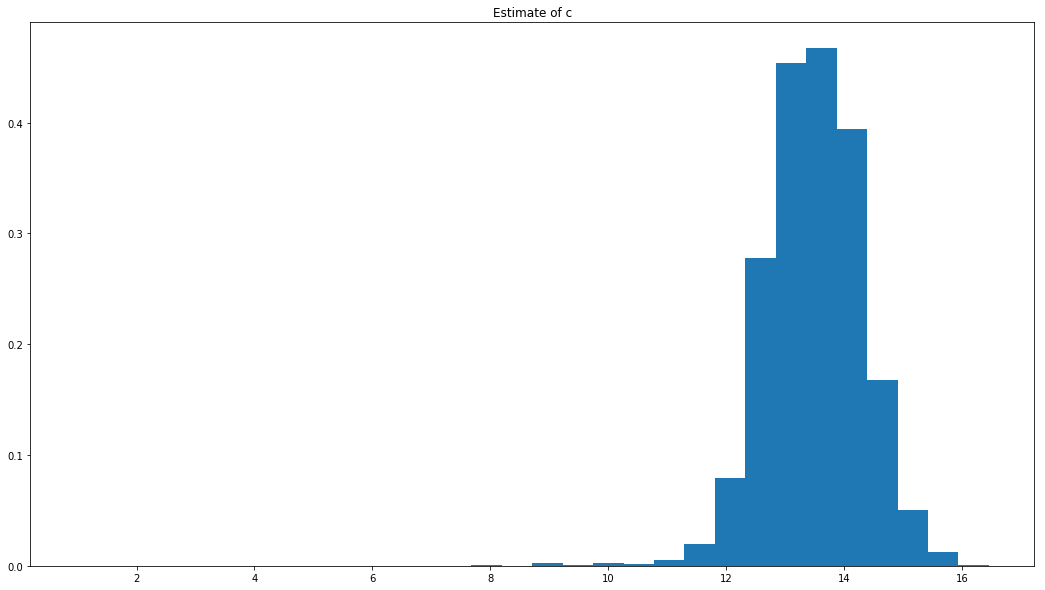

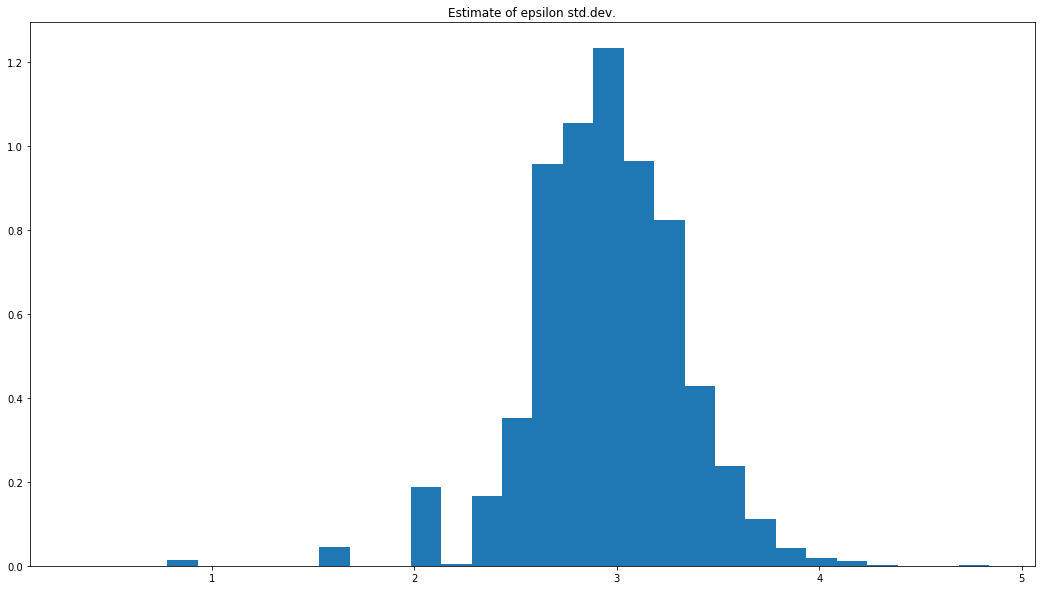

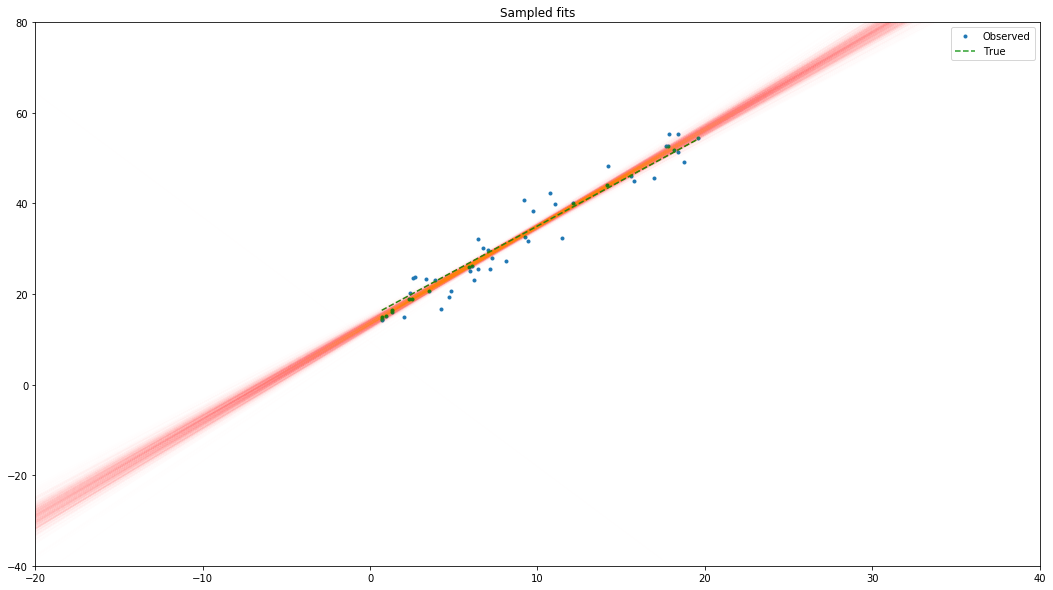

In [12]:
# sample from the distribution
mcmc = mc.MCMC(model)
mcmc.sample(iter=20000)

## plot histograms of possible parameter values
plt.figure()
plt.hist(mcmc.trace("m")[:], normed=True, bins=30)
plt.title("Estimate of m")
plt.figure()
plt.hist(mcmc.trace("c")[:], normed=True, bins=30)
plt.title("Estimate of c")
plt.figure()
plt.hist(np.sqrt(1.0/mcmc.trace("precision")[:]), normed=True, bins=30)
plt.title("Estimate of epsilon std.dev.")
plt.figure()

## now plot overlaid samples from the linear function
ms = mcmc.trace("m")[:]
cs = mcmc.trace("c")[:]

plt.title("Sampled fits")
plt.plot(x, y, '.', label="Observed")
plt.plot(x, x*m+c, '--C2', label="True")
xf = np.linspace(-20,40,200)
for m,c in zip(ms[::20], cs[::20]):    
    plt.plot(xf, xf*m+c, 'C1', alpha=0.005)
plt.legend()
plt.xlim(-20,40)
plt.ylim(-40,80)


## A simple mixture model
We can include both **discrete** and **continuous** variables. A very important case is where we have a **mixture model**. That is, we believe our observations come from one of a number of distributions. For example, in modelling human heights, we might expect height to be normally distributed, but to have two different distributions for men and women.

<img src="imgs/mixture.png">

It is very straightforward to add this to a PyMC graphical model; it is just another random variable to infer.

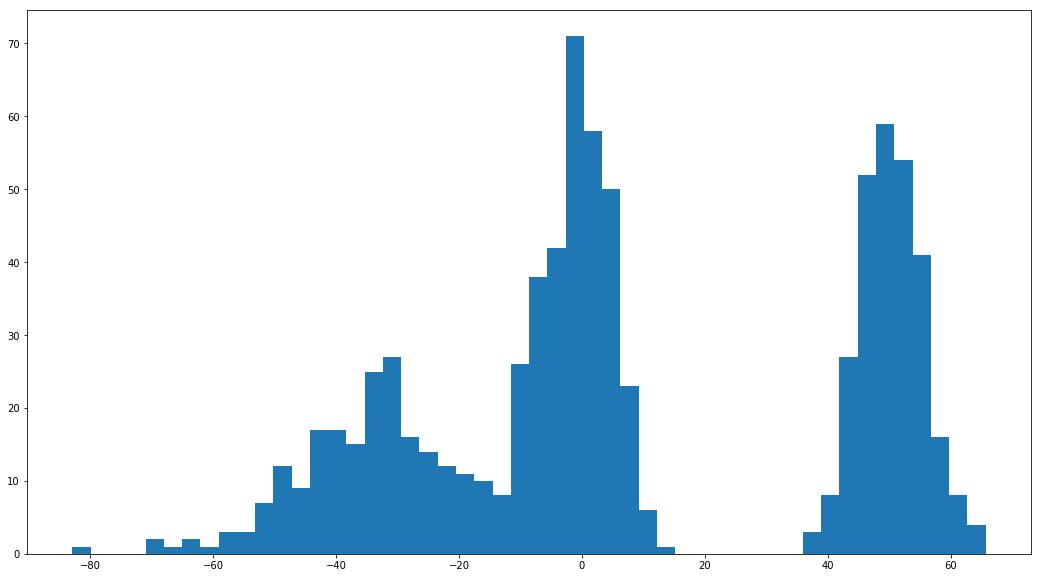

In [13]:
## Adapted from the example given at 
## http://stackoverflow.com/questions/18987697/how-to-model-a-mixture-of-3-normals-in-pymc

n = 3
ndata = 800
## Generate synthetic mixture-of-normals data, with means at -50,0,+50, and std. dev of 1
v = np.random.randint( 0, n, ndata)
data = ((v==0)*(np.random.normal(50,5,ndata)) + 
        (v==1)*(np.random.normal(-30,15,ndata)) + 
        (v==2)*np.random.normal(0,5,ndata))
## Plot the original data
plt.hist(data, bins=50);

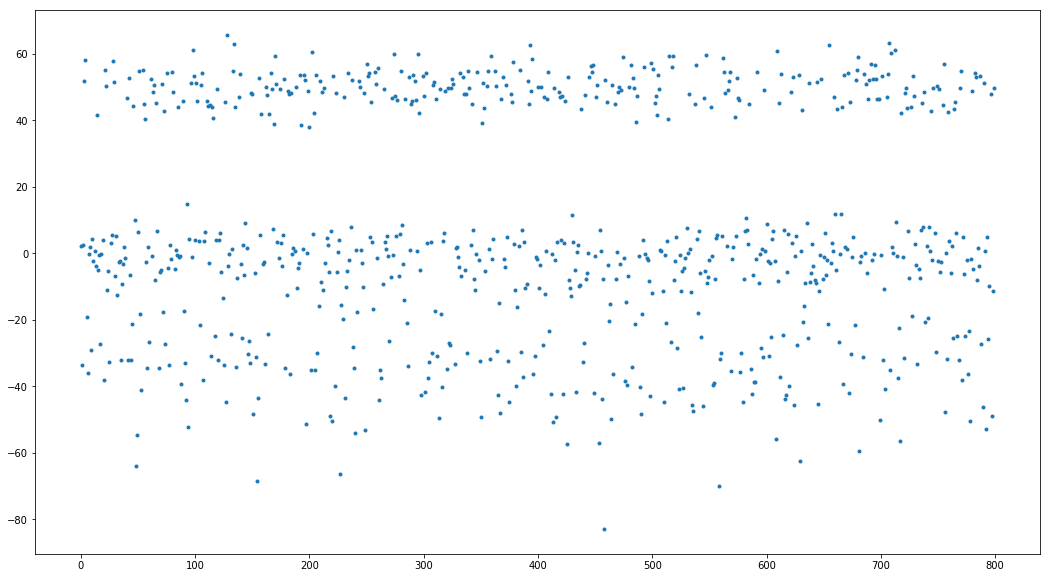

In [14]:
plt.plot(data, '.')

# Graphical model
We model this as a categorical variable, which switches between multiple possible normal distributions.
We have to estimate:
*    the distribution of the categorical variable (i.e. the weightings)
*    the parameters of each normal

----

* We assume we know the *number* of mixtures here (it gets *much* harder to do the inference efficiently if we don't know this)

In [15]:
## A Dirichlet model specifies the distribution over categories
## All 1 means that every category is equally likely
dd = mc.Dirichlet('dd', theta=(1,)*n)

## This variable "selects" the category (i.e. the normal distribution)
## to use. The Dirichlet distribution sets the prior over the categories.
category = mc.Categorical('category', p=dd, size=ndata)

## Now we set our priors the precision and mean of each normal distribution
## Note the use of "size" to generate a **vector** of variables 
## (i.e. one for each category)

## We expect the precision of each normal to be Gamma 
## distributed (this mainly forces it to be positive!)
precs = mc.Gamma('precs', alpha=0.1, beta=0.1, size=n)

## And the means of the normal to be normally distributed, 
## with a precision of 0.001 (i.e. std. dev 1000)
means = mc.Normal('means', 0, 0.001, size=n)

## These deterministic functions link the means of the 
## observed distribution to the categories
## They just select one of the elements of the 
## mean/precision vector, given the current value of category
## The input variables must be specified in the parameters, 
## so that PyMC knows which variables to pass to it
@mc.deterministic
def mean(category=category, means=means):
    return means[category]

@mc.deterministic
def prec(category=category, precs=precs):
    return precs[category]


## Now we specify the variable we observe -- which is normally distributed, *but*
## we don't know the mean or precision. 
## Instead, we pass the **functions** mean() and pred()
## which will be used at each sampling step.
## We specify the observed values of this node, and tell PyMC these are observed 
## This is all that is needed to specify the model
obs = mc.Normal('obs', mean, prec, value=data, observed = True)

## Now we just bundle all the variables together for PyMC
model = mc.Model({'dd': dd,
              'category': category,
              'precs': precs,
              'means': means,
              'obs': obs})

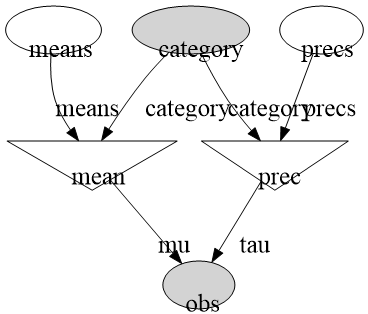

In [109]:

def show_dag(model):
    dag = mc.graph.dag(model)
    dag.write("graph.png",format="png")
    from IPython.display import Image
    i = Image(filename='graph.png')
    return i
    
show_dag(model)    

In [17]:
mcmc = mc.MCMC(model)

## Now we tell the sampler what method to use
## Metropolis works well, but we must tell PyMC to use a specific
## discrete sampler for the category variable to get good results in a reasonable time
mcmc.use_step_method(mc.AdaptiveMetropolis, model.means)
mcmc.use_step_method(mc.AdaptiveMetropolis, model.precs)
mcmc.use_step_method(mc.DiscreteMetropolis, model.category) ## this step is key!
mcmc.use_step_method(mc.AdaptiveMetropolis, model.dd)

## Run the sampler
mcmc.sample(iter=525000, burn=2000)

 [--                6%                  ] 33562 of 525000 complete in 9.0 secHalting at iteration  35113  of  525000


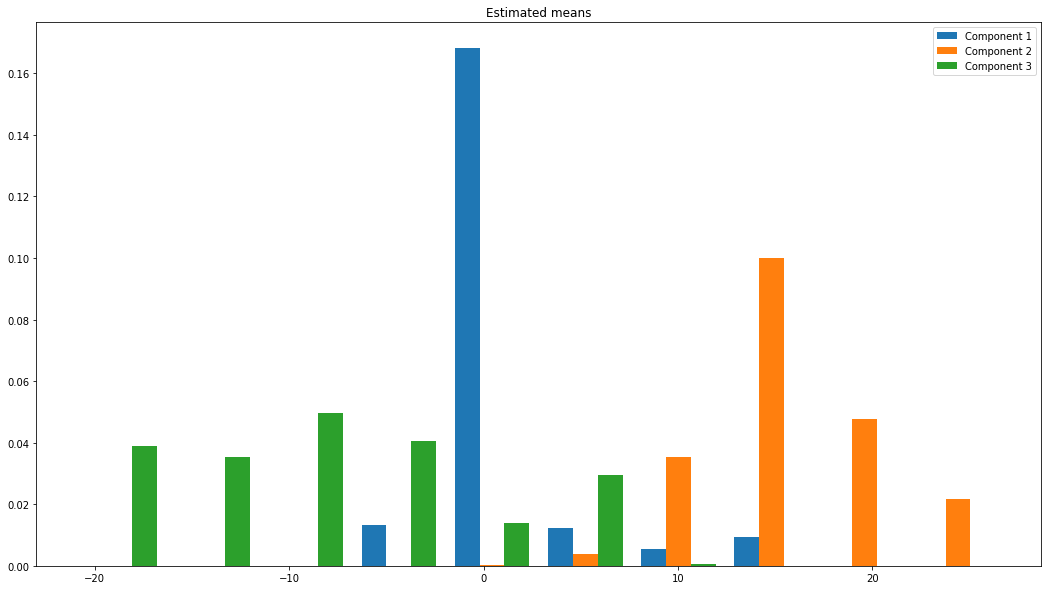

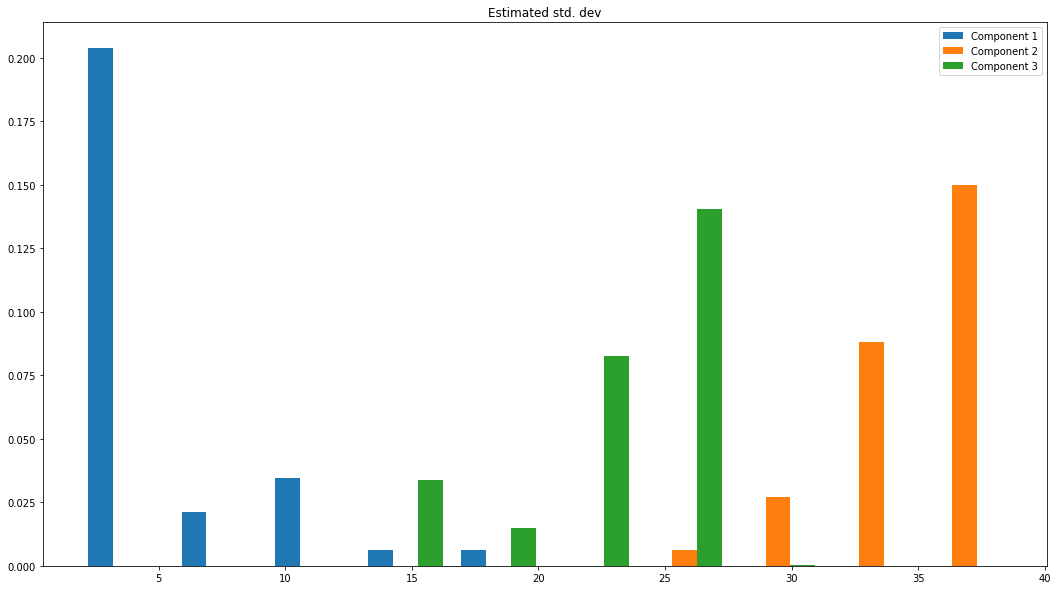

In [18]:
plt.figure()
plt.hist(mcmc.trace('means').gettrace()[:], normed=True)
plt.title("Estimated means")
plt.legend(['Component 1', 'Component 2', 'Component 3'])
plt.figure()
## show the result in terms of std. dev. (i.e sqrt(1.0/precision))
plt.title("Estimated std. dev")
plt.hist(np.sqrt(1.0/mcmc.trace('precs').gettrace()[:]), normed=True)
plt.legend(['Component 1', 'Component 2', 'Component 3'])

------


## Practical: Modelling typing with a MCMC model
<a id="practical"> </a>

You'll build a  simple model which assumes *key hold durations* are assumed to be Lognormal distributed with distribution parameters that are different for each **type** of key; in this example:

* 0: **navigation arrows** 
* 1: **backspace** 
* 2: **printable characters** numbers, letters, punctuation, whitespace

Your task is to estimate the parameters of the Lognormal distribution for each of these three possible key classes, and see if there are any systematic differences. This involves building a model much like the one above, but with a mixture component that is **observed** rather than inferred.

This will be based on a keylog of approximately 6000 key presses (my keypresses editing an old summerschool notebook).

## Steps

1. Load the data
1. Eyeball the data
1. Classify the keys into different types
1. Construct the MCMC model
1. Run it
1. Display the results

Steps 1-3 are provided below. You will need to complete steps 4-6.

For Step 4, You will need to construct the PyMC model specification, then run the MCMC sampler, much as in the example above.  But the inter-key timings should be a Lognormal rather than normal (Gaussian). **Note that this is a mixture model, but unlike the above example, the mixture component is an *observed* variable (you know the key class)**

## 1. Loading data

We can load the data from `keylogs.csv`. This has four columns:

        user_id  delta_t  duration_t  keycode

`user_id` is a unique integer per-user (there is only one user here). Time (`delta_t`) is in milliseconds *since the previous keydown event*.  `duration_t` is the duration the key was held down, in milliseconds. `keycode` is the keycode (result of `e.which` in Javascript) of the keypress.
       

In [7]:
    keylog = pd.read_csv('jupyter_keylog.csv', 
                         names=['user_id', 'delta_t', 'duration_t', 'keycode'])

In [8]:
print(keylog.describe())

           user_id        delta_t     duration_t      keycode
count       6012.0    6012.000000    6012.000000  6012.000000
mean   240782504.0     535.208081    1032.532693    57.819860
std            0.0   16897.180744   14928.526299    42.977185
min    240782504.0       0.150000       3.890000     8.000000
25%    240782504.0      67.395000      96.742500    32.000000
50%    240782504.0      85.425000     138.475000    59.000000
75%    240782504.0     104.235000     226.160000    78.000000
max    240782504.0  876695.505000  674341.140000   222.000000


## 2. Eyeballing data
Histograms are a quick way to visualise the distributions. You can try alternative visualisations if 
you are interested (e.g. a scatterplot of `duration_t` versus `delta_t`).

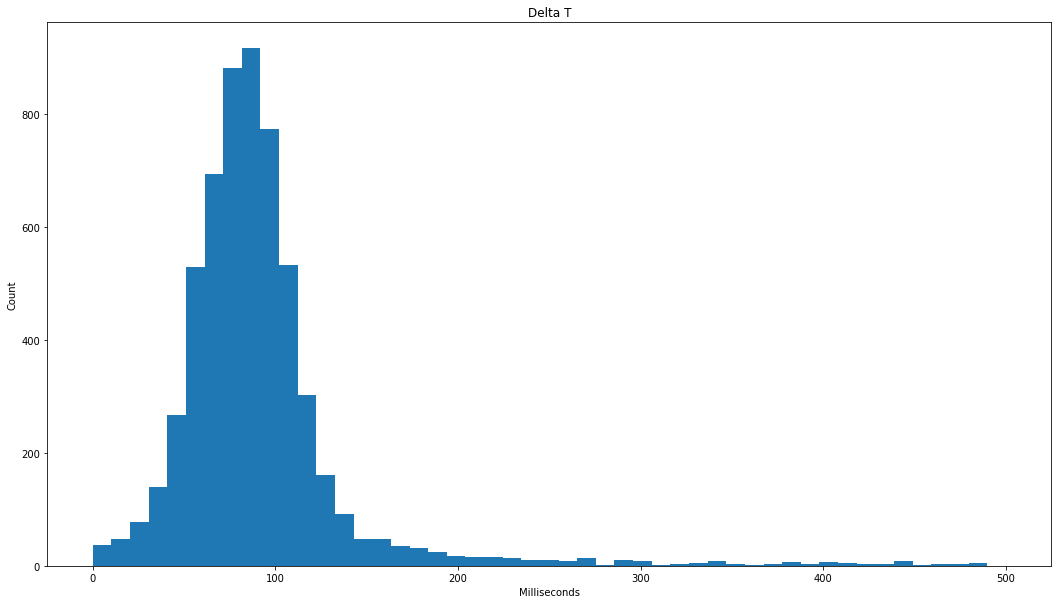

In [9]:
plt.hist(keylog.delta_t, bins=np.linspace(0,500,50))
plt.title("Delta T")
plt.xlabel("Milliseconds")
plt.ylabel("Count")

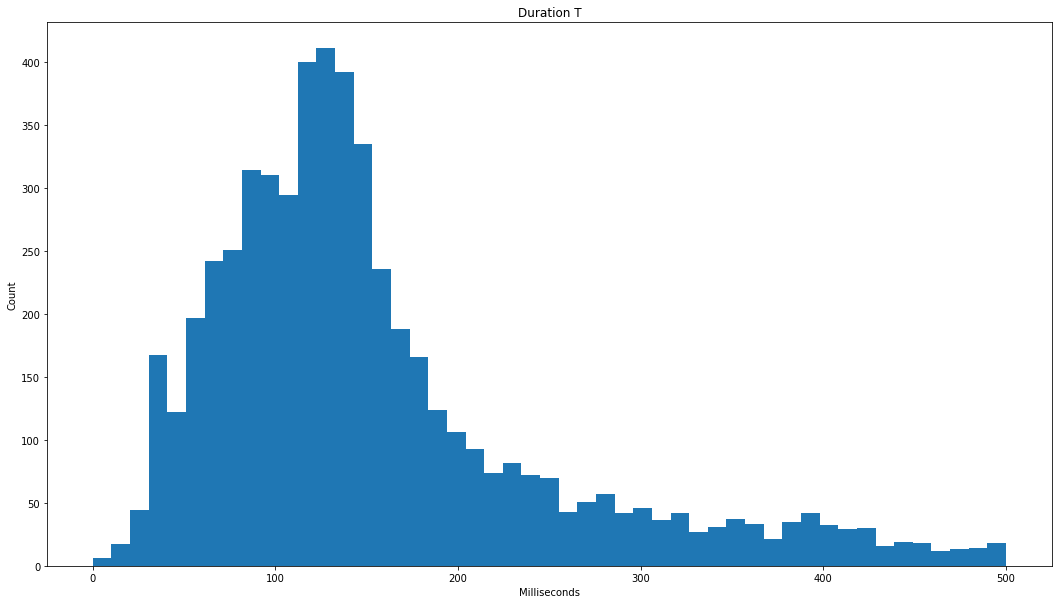

In [10]:
plt.hist(keylog.duration_t, bins=np.linspace(0,500,50));
plt.title("Duration T")
plt.xlabel("Milliseconds")
plt.ylabel("Count")

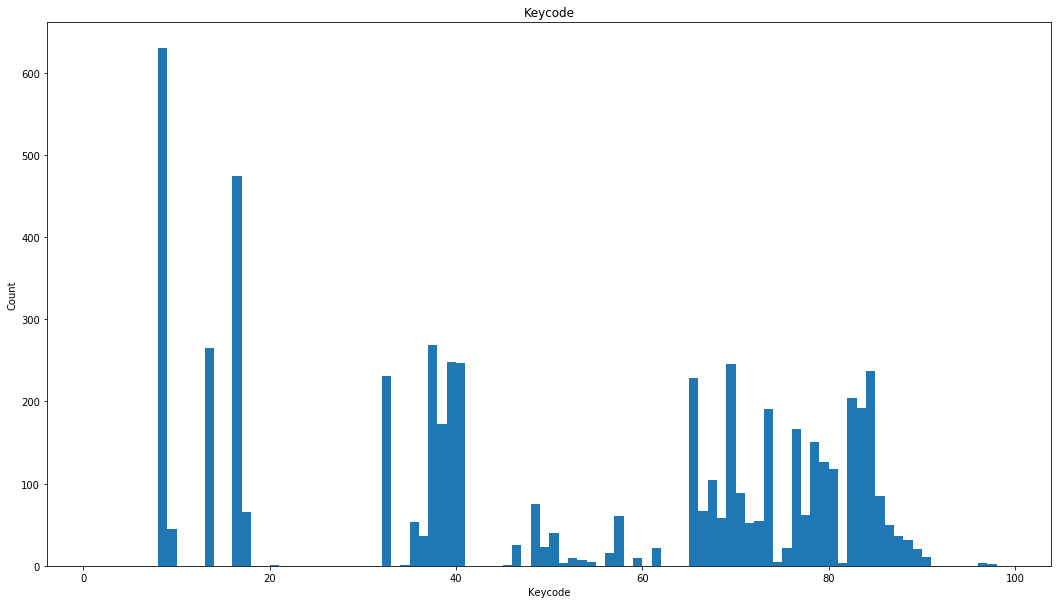

In [11]:
plt.hist(keylog.keycode, bins=np.arange(1,100));
plt.title("Keycode")
plt.xlabel("Keycode")
plt.ylabel("Count")

## 3. Classifying keys

In [12]:
import keys
# these are all the key types known to the keys module
print(keys.get_key_types())

['letters', 'caps_lock', 'locks', 'numbers', 'tab', 'top_block', 'f_block', 'all_locks', 'whitespace', 'shifts', 'backspace', 'special', 'nav', 'allkeys', 'function', 'numpad', 'punct', 'delchar', 'ext_numpad', 'editing', 'insert_delete', 'web_nav', 'home_end', 'arrows', 'character_keys', 'enter', 'modifier', 'page', 'nonprint']


In [13]:
# convert a list of keycodes to their names
print(keys.key_to_name(keylog.keycode[0:100]))

['enter', 'period', 'd', 'a', 't', 'a', 'enter', 'shift', 'left arrow', 'comma', '(space)', 'c', None, 'i', 'r', 'i', 's', 'period', 't', 'a', 'r', 'g', 'e', 't', 's', 'enter', 'shift', 'delete', 'enter', 'shift', 's', 'c', 'a', 't', 't', 'e', 'r', 'enter', 'shift', 'backspace', 'home', 'right arrow', 'right arrow', 'right arrow', 'right arrow', 'right arrow', 'right arrow', 'right arrow', 'right arrow', 'right arrow', 'right arrow', 'right arrow', 'shift', 'p', 'l', 'o', 't', 'end', 'left arrow', 'period', 't', 'enter', 'shift', None, 'up arrow', 'end', 'shift', 'down arrow', 'left arrow', 'left arrow', 'comma', '(space)', 'c', None, '(space)', 'i', 'r', 'i', 'backspace', 'backspace', 'backspace', 'backspace', 'i', 'r', 'i', 's', 'shift', 'period', 'd', 'a', 't', 'a', 'period', 't', 'shift', 'backspace', 'backspace', 'backspace', 'backspace', 'backspace']


#### Getting class indices

The easiest way to encode information for the MCMC model is to use integer indices for each key, so that a standard `Categorical` variable type can be used.

To classify keys into discrete classes, we can use `keys.classify_keys(k, classes)`. This takes a list of possible classes, and for each key, indicates which classes it belongs to. This will be a list of indices. The list will be empty if the key does not fall into any of the specified classes.

In [14]:
print(keys.classify_keys(keylog.keycode[0:100], ['letters', 'backspace']))

[[], [], [0], [0], [0], [0], [], [], [], [], [], [0], [], [0], [0], [0], [0], [], [0], [0], [0], [0], [0], [0], [0], [], [], [], [], [], [0], [0], [0], [0], [0], [0], [0], [], [], [1], [], [], [], [], [], [], [], [], [], [], [], [], [], [0], [0], [0], [0], [], [], [], [0], [], [], [], [], [], [], [], [], [], [], [], [0], [], [], [0], [0], [0], [1], [1], [1], [1], [0], [0], [0], [0], [], [], [0], [0], [0], [0], [], [0], [], [1], [1], [1], [1], [1]]


## Creating the final dataset for inference
We classify the keys into `arrow`, `backspace` and `character_keys` as the three classes. Since each key can only belong to one of these classes, filter this into a list of integers, one per key, with `None` for keys not having any of these classes.

In [113]:
class_names = ['arrows', 'backspace', 'character_keys']
classes = keys.classify_keys(keylog.keycode, class_names)
filtered_classes = [c[0] if len(c)>0 else None for c in classes]
print(filtered_classes[0:100])

[None, 2, 2, 2, 2, 2, None, None, 0, 2, 2, 2, None, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, None, None, None, None, None, 2, 2, 2, 2, 2, 2, 2, None, None, 1, None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 2, 2, 2, 2, None, 0, 2, 2, None, None, None, 0, None, None, 0, 0, 0, 2, 2, 2, None, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, None, 2, 2, 2, 2, 2, 2, 2, None, 1, 1, 1, 1, 1]


Then we filter both the keycodes *and* the corresponding `duration_t`, removing any `None` keys, to create two new lists:
* a list of class codes
* a list of corresponding durations


In [114]:
class_codes = []
durations = []
for key_class, duration in zip(filtered_classes, keylog.duration_t):
    if key_class is not None:
        class_codes.append(key_class)
        durations.append(duration)
        

## Dataset complete
This is our final dataset for the MCMC model.

In [119]:
print(class_codes[0:100])
print()
print(durations[0:100])

[2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2]
()
[5224.665, 90.795000000000002, 151.47499999999999, 70.579999999999998, 94.034999999999997, 3512.5300000000002, 516.38999999999999, 114.765, 88.965000000000003, 456.48000000000002, 79.784999999999997, 103.035, 134.38, 126.69499999999999, 308.5, 99.129999999999995, 77.849999999999994, 167.08000000000001, 39.674999999999997, 83.125, 209.95500000000001, 3058.1500000000001, 112.64, 204.63499999999999, 149.96000000000001, 162.58000000000001, 243.79499999999999, 56.354999999999997, 2810.8899999999999, 181.87, 131.98500000000001, 112.95, 126.075, 83.525000000000006, 101.685, 131.97999999999999, 120.44, 136.72999999999999, 91.890000000000001, 201.11000000000001, 388.69999999999999, 144.0399999999

## 4. Construct the model

## Hints
* Use a prior of `p=[1/3.0, 1/3.0, 1/3.0]` for the Categorical variable (even though it is observed, a value for `p` is required)
* You can reuse the same priors for mean and prec as in the previous example (the parameters of the priors have little effect on the inference, as you can check yourself)
* Show your model with `show_dag()` before running it.

In [116]:
# Solution
category = mc.Categorical('category', p=[1/3.0, 1/3.0, 1/3.0], observed=True, value=class_codes)

## We expect the precision of each normal to be Gamma 
## distributed (this mainly forces it to be positive!)
precs = mc.Gamma('precs', alpha=0.5, beta=0.5, size=3)

## And the means of the normal to be normally distributed, 
## with a precision of 0.001 (i.e. std. dev 1000)
means = mc.Normal('means', 0, 0.01, size=3)

@mc.deterministic
def mean(category=category, means=means):
    return means[category]

@mc.deterministic
def prec(category=category, precs=precs):
    return precs[category]

obs = mc.Lognormal('obs', mean, prec, value=durations, observed = True)

## Now we just bundle all the variables together for PyMC
model = mc.Model({
              'category': category,
              'precs': precs,
              'means': means,
              'obs': obs})

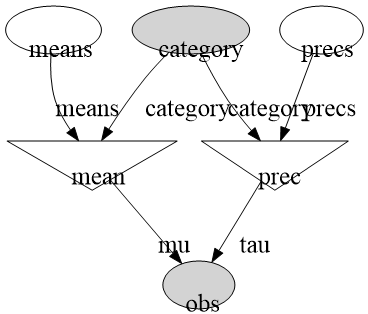

In [117]:
# Solution
show_dag(model)

## 5. Run the model

In [118]:
## Solution
mcmc = mc.MCMC(model)

mcmc.use_step_method(mc.AdaptiveMetropolis, model.means)
mcmc.use_step_method(mc.AdaptiveMetropolis, model.precs)

## Run the sampler
mcmc.sample(iter=525000, burn=10000)

 [-----------------100%-----------------] 525000 of 525000 complete in 147.2 sec

## 6. Report the results
* You can use the traces above
* It is also informative to try drawing samples from the posterior distributions. PyMC2 has no convenient method to do this directly (PyMC3 does), but you can just iterate through a bunch of the mean/prec, and then sample from a corresponding distribution.

In PyMC, sampling from any distribution can be done using mc.r[XXX], where [XXX] is the lowercase distribution name. 
    
    rnormal(0, 1) # draw a sample from Normal, mean=0, precision=1
    rlognormal(0, 1) # draw a sample from the log Normal with u=0, precision=1
    rgamma(0.1, 0.1) # draw a sample from the Gamma distribution with  alpha=0.1, beta = 0.1


In [120]:
# 5 samples from lognormal, mu=0, prec=1
mc.rlognormal(0,1,size=5)

array([ 2.1162346 ,  1.31872892,  7.67685862,  1.56387655,  0.89399018])

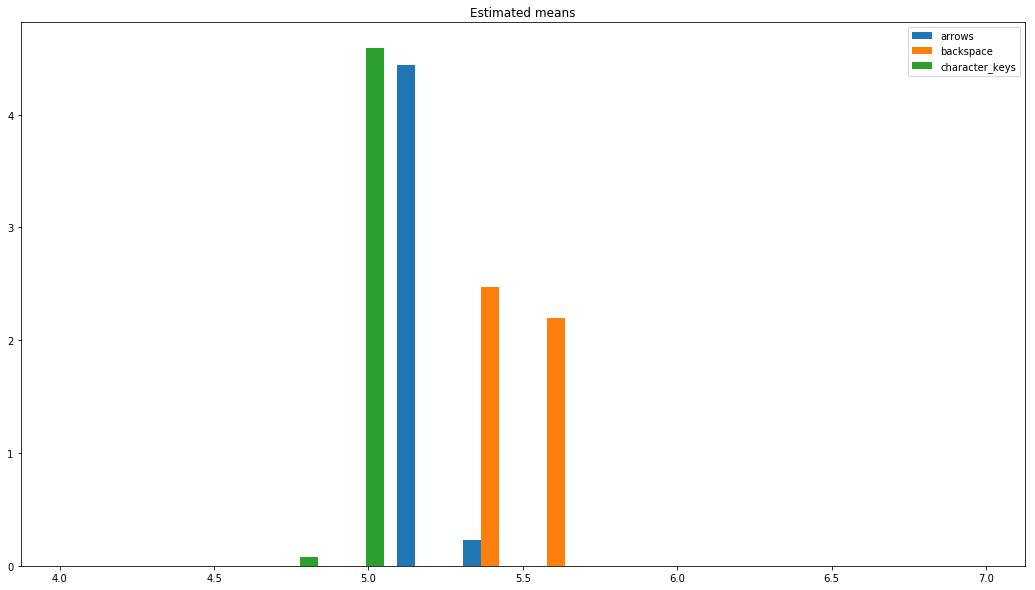

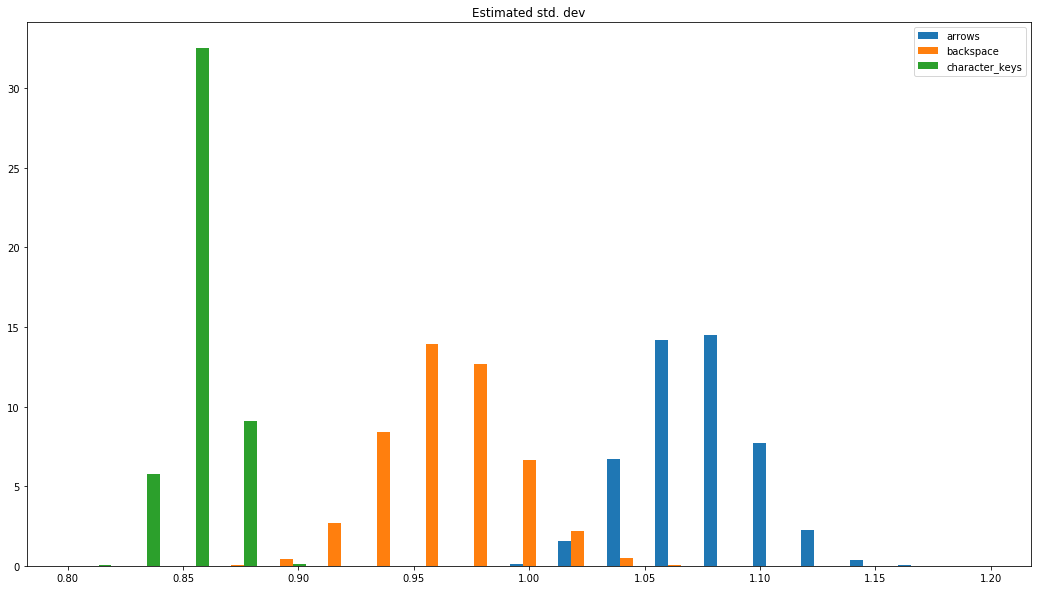

In [121]:
# Solution
# The trace histograms
plt.figure()
plt.hist(mcmc.trace('means').gettrace()[:], normed=True, bins=np.linspace(4,7,15))
plt.title("Estimated means")
plt.legend(class_names)
plt.figure()
## show the result in terms of std. dev. (i.e sqrt(1.0/precision))
plt.title("Estimated std. dev")
plt.hist(np.sqrt(1.0/mcmc.trace('precs').gettrace()[:]), normed=True, bins=np.linspace(0.8, 1.2, 20))
plt.legend(class_names)

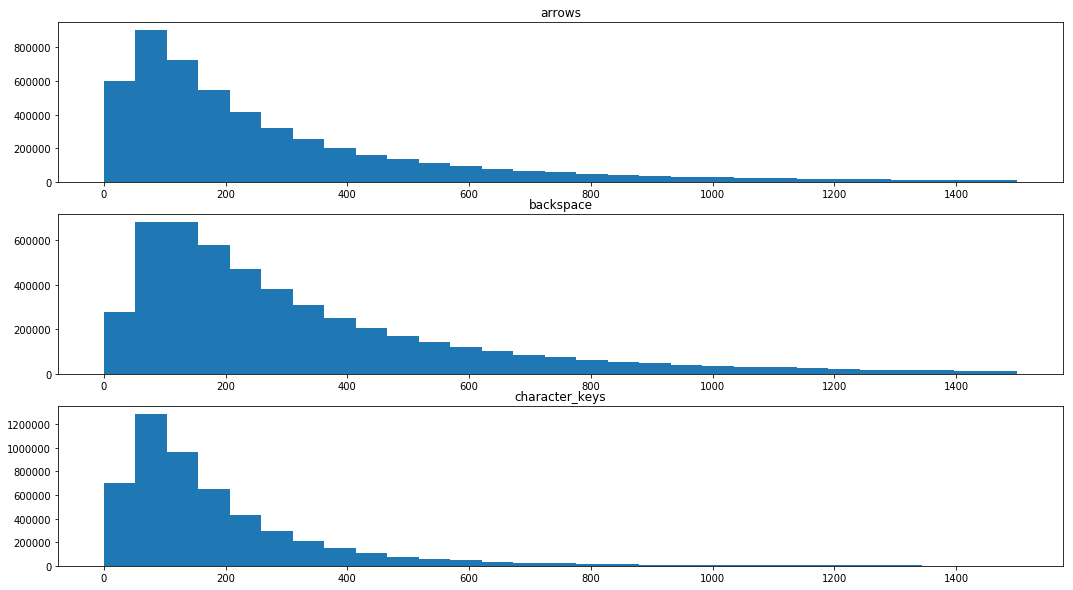

In [122]:
# Solution
# predictive posterior
means = mcmc.trace('means').gettrace()[:]
precs = mcmc.trace('precs').gettrace()[:]


key_samples = []
for key_class in range(3):
    samples = []
    for m, p in zip(means[:,key_class], precs[:,key_class]):
        for i in range(10):
            samples.append(mc.rlognormal(m,p))
    key_samples.append(samples)

labels = class_names
for i,k in enumerate(key_samples):
    plt.subplot(3,1,i+1)
    plt.title(labels[i])
    plt.hist(k, bins=np.linspace(0,1500,30));

# Further thoughts
There are lots of interesting things we could also have done with just this subset of the data (class + duration):
* Explored different models for the time distribution (e.g. Gamma instead of lognormal)
* Predicted the key class *given* the duration.
* Try **clustering** the durations (e.g. with a Dirichlet process) and see if we can infer groupings of key behaviour that correspond to key classes or keyboard locations.


# Link to [Inferring Typing Behaviour: Part II](static_2.ipynb)
